### **NLTK SENTIMENT SCORING WITH SNOWPARK**

#### 🛑 IMPORTANT! Snowpark requires Python 3.8! 
#### **Please download this Notebook as a Jupyter file and run it local on a Python 3.8 environment.** 

# 1. Install Snowpark & NLTK for Python 

In [ ]:
!pip install snowflake-snowpark-python
!pip install nltk

# Write a NLTK Sentiment Python Function (No Snowpark Yet) 

In [80]:
import nltk
from nltk.sentiment import SentimentIntensityAnalyzer

# ---> Download the language model & create an object reference
nltk.download('vader_lexicon')
my_ntlk = SentimentIntensityAnalyzer()

# -- Build a Python function using NLTK library to return a sentiment score based on a text input
def GetSentiment(review: str) -> float:
    return my_ntlk.polarity_scores(review)["compound"]

# Test the Python function on local compute

GoodScore = GetSentiment('This was best & most awesome movie ever')
BadScore = GetSentiment('This is the worst book')

print(f'Good score = {GoodScore}  &  BadScore = {BadScore}        \n\n\n')


Good score = 0.8622  &  BadScore = -0.6249        





[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/nakincilar/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


# 2. Import libraries, Connect to Snowflake & Create Environment

**Modify your Snowflake Account & User credentials in this section**

**Run this SQL on your Snowflake account to get the account name**

``` sql
SELECT SPLIT_PART(VALUE:host::string , '.',1) AS SNOWFLAKE_ACCOUNT_LOCATOR
from table(flatten(parse_json(SYSTEM$ALLOWLIST())))
where VALUE:type::string = 'SNOWFLAKE_DEPLOYMENT_REGIONLESS'
```

In [81]:

import time

from snowflake.snowpark import Session, DataFrame
from snowflake.snowpark.functions import udf, col
import snowflake.snowpark.functions as f
from snowflake.snowpark.functions import udf
from snowflake.snowpark.types import IntegerType
from snowflake.snowpark.functions import call_udf


# --> EDIT THIS WITH YOUR ACCOUNT & CREDS  
CONNECTION_PARAMETERS= {
    'account': 'Snowflake_Account_Locator',
    'user': 'Your_User',
    'password': 'Your_PW'
}

print("Connecting to Snowflake.....\n")

session = Session.builder.configs(CONNECTION_PARAMETERS).create()
print("Connected Successfully!..\n\n")

# Create the necessary Compute warehouse, Database, Schema & Stage to link to S3 Sample data
print("Creating Snowflake objects (DB, Schema, FileFormat, Stage & Warehouse/Compute ")

Warehouse_Name = 'MY_DEMO_WH'
Warehouse_Size = 'X-LARGE'
DB_name = 'DEMO_SNOWPARK'
Schema_Name = 'Public'

sql_cmd = f"CREATE OR REPLACE WAREHOUSE {Warehouse_Name} WAREHOUSE_SIZE = 'MEDIUM' AUTO_SUSPEND = 10 "
session.sql(sql_cmd).collect() 

session.use_warehouse(Warehouse_Name)

sql_cmd = "CREATE DATABASE IF NOT EXISTS {}".format(DB_name)
session.sql(sql_cmd).collect() 

session.use_database(DB_name)
session.use_schema(Schema_Name)

session.sql("CREATE OR REPLACE STAGE my_s3_stage URL = 's3://amazon-reviews-pds/parquet/' ").collect()
session.sql('CREATE OR REPLACE STAGE PythonUDF_Stage').collect()
print('Demo Enviroment with MEDIUM Compute is Created!')



Connecting to Snowflake.....

Connected Successfully!..


Creating Snowflake objects (DB, Schema, FileFormat, Stage & Warehouse/Compute 
Demo Enviroment with MEDIUM Compute is Created!


# 3. Ingest 6M Amazon reviews from parquet on S3. 
####  **Create, Upload & Register a custom Python function(NLTK) to Snowflake** 

Below test is for Apperal Category with 6M reviews. Fullset in this S3 bucket contains 160M product reviews.

If you want to test it with a full set of 160M reviews, **enable lines 5 & 6**(removes references to the single file & Scales up the warehouse to 3XL), you should be able to score all **160M reviews in about 4 mins & 45 secs.** in which it scale down to XS once done.

🛑 **CAUTION. Make sure scale down command executes as 3XL can consume credits fast if left running.** If not, you can manually do it from UI or via SQL.



In [78]:



# 1. Read data directly in to Snowpark dataframe from a parquet file (Schema Detection for column names)
location = '@my_s3_stage/product_category=Apparel/'

session.sql(f'list {location}').collect()

# - Get the total file size of Source 
s3_size =  session.sql('select count(1) as File_Count, sum($2/1024/1024/1024)::number(10,2) as Parquet_Size_In_GB FROM table(result_scan(last_query_id()))')
s3_size.show()

print("Importing Reviews data from S3....")
start_time = time.time()

# - Ingest data from S3 Parquet files
df_reviews = session.read.option("compression", "snappy").parquet(location)

# - UPPERCASE all column names to fix any mixed column names
for Mycol in df_reviews.columns:
    df_reviews = df_reviews.withColumnRenamed(Mycol, Mycol.upper())

# - Store the ingested data into Snowflake Table
df_reviews.write.mode("overwrite").saveAsTable("AMAZON_REVIEWS")


end_time = time.time()
print("--- %s seconds to Ingest 6M rows into a Table --- \n" % int(end_time - start_time))

# - Get the size of the Snowflake table after the ingestion 
table_size = session.sql("SELECT TABLE_CATALOG, TABLE_NAME,(BYTES / 1024/1024/1024)::number(10,2) AS Snowflake_Size_In_GB\
                         FROM DEMO_SNOWPARK.INFORMATION_SCHEMA.TABLES WHERE TABLE_CATALOG = 'DEMO_SNOWPARK' AND TABLE_NAME = 'AMAZON_REVIEWS' ") 
table_size.show()


# - Reference the Snowflake Table
df_reviews = session.table("AMAZON_REVIEWS")


print("Reviews Ingested: ", df_reviews.count() )

# - Filter the reviews with over 50 characters
df_reviews = df_reviews.filter(f.length( col("review_body")) > 50 )

print("Reviews to Score: ", df_reviews.count())
df_reviews.show()


# Tell Snowpark to add NLTK library from Anaconda (You can also manually upload any compatible 3rd party library if it is not available via Anaconda)
session.add_packages("nltk")

# 3. Upload & register the Python function + NLTK libray to Snowflake

print("\n\nUploading & Registering Python Function as a Snowflake UDF....")
register_udf = session.udf.register(GetSentiment, name="GetSentiment", is_permanent=True, replace=True,
                                    stage_location="@PythonUDF_Stage/PythonUDFS")

print("Upload Successful!")


---------------------------------------
|"FILE_COUNT"  |"PARQUET_SIZE_IN_GB"  |
---------------------------------------
|10            |1.12                  |
---------------------------------------

Importing Reviews data from S3....
-------------------------------------------------------------
|"TABLE_CATALOG"  |"TABLE_NAME"    |"SNOWFLAKE_SIZE_IN_GB"  |
-------------------------------------------------------------
|DEMO_SNOWPARK    |AMAZON_REVIEWS  |0.70                    |
-------------------------------------------------------------

--- 23 seconds to Ingest 6M rows into a Table --- 

Reviews Ingested:  5906460
Reviews to Score:  4431294
------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|"MARKETPLACE"  

The version of package nltk in the local environment is 3.8.1, which does not fit the criteria for the requirement nltk. Your UDF might not work when the package version is different between the server and your local environment




Uploading & Registering Python Function as a Snowflake UDF....
Upload Successful!


# 4. Score 4.5M Reviews & Write Results to a new Snowflake Table.

In [ ]:
print("Start the Sentiment Analysis & Write results to a new table called AMAZON_REVIEWS_RESULTS....")

print(f"Scaling Up the warehouse to {Warehouse_Size}..\n")
sql_cmd = f"ALTER WAREHOUSE {Warehouse_Name} SET WAREHOUSE_SIZE = '{Warehouse_Size}'"
session.sql(sql_cmd).collect() 

print("Starting Sentiment Scoring Process...\n")
start_time = time.time()

# 5. Start the Sentiment Scoring Process by running the Python function in Snowflake
final_df = df_reviews.group_by(col("review_date"),col("review_id"), col("product_id"),  col("review_body")).agg(call_udf("GetSentiment", col("review_body")).alias("score"))

# 6. Write the resulting dataset to new table
final_df.write.mode("overwrite").saveAsTable("AMAZON_REVIEWS_RESULTS")

end_time = time.time()

print("--- %s seconds to Sentiment Analysis & Write the Results to Table --- \n" % int(end_time - start_time))
print("Reviews Scored: ", final_df.count())
final_df.show()

# ---DONE !!!

# 7 - SCALE DOWN COMPUTE TO 1 NODE
print("Reducing the warehouse to XS..\n")
sql_cmd = "ALTER WAREHOUSE {} SET WAREHOUSE_SIZE = 'XSMALL'".format(Warehouse_Name)
session.sql(sql_cmd).collect()  

print("Completed!...\n")

# 5. Now you can even use your new PYTHON function directly via SQL from other BI tools. It is production ready & will scale via Warehouse Size

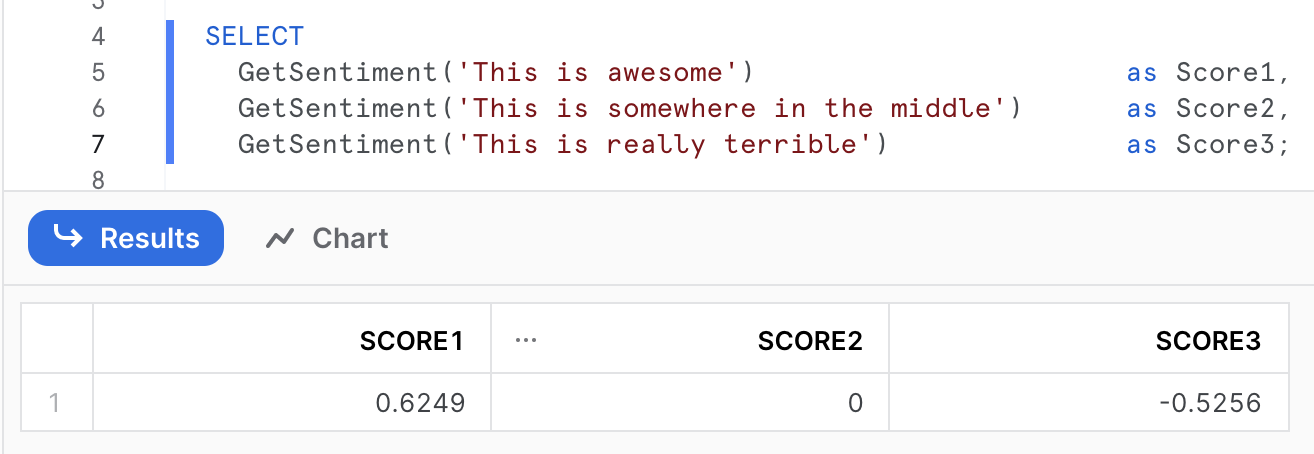


In [ ]:
sql_cmd = "ALTER WAREHOUSE {} SET WAREHOUSE_SIZE = 'XSMALL'".format(Warehouse_Name)
session.sql(sql_cmd).collect()  